In [1]:
### 라이브러리 및 데이터 불러오기
# 필요한 라이브러리를 불러온다.
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import pickle

# 데이터 전처리 방식을 지정한다.
transform = transforms.Compose([
        transforms.ToTensor(), # 데이터를 PyTorch의 Tensor 형식으로 바꾼다.
        transforms.Normalize(mean=(0.5,), std=(0.5,)) # 픽셀값 0 ~ 1 -> -1 ~ 1
])

# MNIST 데이터셋을 불러온다. 지정한 폴더에 없을 경우 자동으로 다운로드한다.
mnist = datasets.MNIST(root='data', download=True, transform=transform)

# 데이터를 한번에 batch_size만큼만 가져오는 dataloader를 만든다.
dataloader = DataLoader(mnist, batch_size=60, shuffle=True)

In [2]:
import os
import imageio

if torch.cuda.is_available():
    use_gpu = True
leave_log = True
if leave_log:
    result_dir = 'GAN_generated_images'
    if not os.path.isdir(result_dir):
        os.mkdir(result_dir)

In [3]:
### GAN의 생성자(Generator)
# 생성자는 랜덤 벡터 z를 입력으로 받아 가짜 이미지를 출력한다.
class Generator(nn.Module):

    # 네트워크 구조
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=100, out_features=256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(in_features=256, out_features=512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(in_features=512, out_features=1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(in_features=1024, out_features=28*28),
            nn.Tanh())
    
    # (batch_size x 100) 크기의 랜덤 벡터를 받아 
    # 이미지를 (batch_size x 1 x 28 x 28) 크기로 출력한다.
    def forward(self, inputs):
        return self.main(inputs).view(-1, 1, 28, 28)

In [4]:
### GAN의 구분자(Discriminator)
# 구분자는 이미지를 입력으로 받아 이미지가 진짜인지 가짜인지 출력한다.
class Discriminator(nn.Module):
    
    # 네트워크 구조
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=1024),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Dropout(inplace=True),
            nn.Linear(in_features=1024, out_features=512),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Dropout(inplace=True),
            nn.Linear(in_features=512, out_features=256),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Dropout(inplace=True),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid())
    
    # (batch_size x 1 x 28 x 28) 크기의 이미지를 받아
    # 이미지가 진짜일 확률을 0~1 사이로 출력한다.
    def forward(self, inputs):
        inputs = inputs.view(-1, 28*28)
        return self.main(inputs)

In [5]:
### 생성자와 구분자 객체 만들기
G = Generator()
D = Discriminator()

if use_gpu:
    G.cuda()
    D.cuda()

In [6]:
### 손실 함수와 최적화 기법 지정하기
# Binary Cross Entropy loss
criterion = nn.BCELoss()

# 생성자의 매개 변수를 최적화하는 Adam optimizer
G_optimizer = Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
# 구분자의 매개 변수를 최적화하는 Adam optimizer
D_optimizer = Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [7]:
# 학습 결과 시각화하기
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

def square_plot(data, path):
    """Take an array of shape (n, height, width) or (n, height, width , 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""

    if type(data) == list:
	    data = np.concatenate(data)
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))

    padding = (((0, n ** 2 - data.shape[0]) ,
                (0, 1), (0, 1))  # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data , padding, mode='constant' , constant_values=1)  # pad with ones (white)

    # tilethe filters into an image
    data = data.reshape((n , n) + data.shape[1:]).transpose((0 , 2 , 1 , 3) + tuple(range(4 , data.ndim + 1)))

    data = data.reshape((n * data.shape[1] , n * data.shape[3]) + data.shape[4:])

    plt.imsave(path, data, cmap='gray')

In [8]:
if leave_log:
    train_hist = {}
    train_hist['D_losses'] = []
    train_hist['G_losses'] = []
    generated_images = []
    
z_fixed = Variable(torch.randn(5 * 5, 100), volatile=True)
if use_gpu:
    z_fixed = z_fixed.cuda()

<ipython-input-8-8b401d4d980b>:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  z_fixed = Variable(torch.randn(5 * 5, 100), volatile=True)


In [13]:
### 모델 학습을 위한 반복문
# 데이터셋을 100번 돌며 학습한다.
for epoch in range(100):
    
    if leave_log:
        D_losses = []
        G_losses = []
    
    # 한번에 batch_size만큼 데이터를 가져온다.
    for real_data, _ in dataloader:
        batch_size = real_data.size(0)
        
        # 데이터를 pytorch의 변수로 변환한다.
        real_data = Variable(real_data)

        ### 구분자 학습시키기

        # 이미지가 진짜일 때 정답 값은 1이고 가짜일 때는 0이다.
        # 정답지에 해당하는 변수를 만든다.
        target_real = Variable(torch.ones(batch_size, 1))
        target_fake = Variable(torch.zeros(batch_size, 1))
         
        if use_gpu:
            real_data, target_real, target_fake = real_data.cuda(), target_real.cuda(), target_fake.cuda()
            
        # 진짜 이미지를 구분자에 넣는다.
        D_result_from_real = D(real_data)
        # 구분자의 출력값이 정답지인 1에서 멀수록 loss가 높아진다.
        D_loss_real = criterion(D_result_from_real, target_real)

        # 생성자에 입력으로 줄 랜덤 벡터 z를 만든다.
        z = Variable(torch.randn((batch_size, 100)))
        
        if use_gpu:
            z = z.cuda()
            
        # 생성자로 가짜 이미지를 생성한다.
        fake_data = G(z)
        
        # 생성자가 만든 가짜 이미지를 구분자에 넣는다.
        D_result_from_fake = D(fake_data)
        # 구분자의 출력값이 정답지인 0에서 멀수록 loss가 높아진다.
        D_loss_fake = criterion(D_result_from_fake, target_fake)
        
        # 구분자의 loss는 두 문제에서 계산된 loss의 합이다.
        D_loss = D_loss_real + D_loss_fake
        
        # 구분자의 매개 변수의 미분값을 0으로 초기화한다.
        D.zero_grad()
        # 역전파를 통해 매개 변수의 loss에 대한 미분값을 계산한다.
        D_loss.backward()
        # 최적화 기법을 이용해 구분자의 매개 변수를 업데이트한다.
        D_optimizer.step()
        
        if leave_log:
            D_losses.append(D_loss.data.item())

        # train generator G

        ### 생성자 학습시키기
        
        # 생성자에 입력으로 줄 랜덤 벡터 z를 만든다.
        z = Variable(torch.randn((batch_size, 100)))
        
        if use_gpu:
            z = z.cuda()
        
        # 생성자로 가짜 이미지를 생성한다.
        fake_data = G(z)
        # 생성자가 만든 가짜 이미지를 구분자에 넣는다.
        D_result_from_fake = D(fake_data)
        # 생성자의 입장에서 구분자의 출력값이 1에서 멀수록 loss가 높아진다.
        G_loss = criterion(D_result_from_fake, target_real)
        
        # 생성자의 매개 변수의 미분값을 0으로 초기화한다.
        G.zero_grad()
        # 역전파를 통해 매개 변수의 loss에 대한 미분값을 계산한다.
        G_loss.backward()
        # 최적화 기법을 이용해 생성자의 매개 변수를 업데이트한다.
        G_optimizer.step()
        
        if leave_log:
            G_losses.append(G_loss.data.item())
    if leave_log:
        true_positive_rate = (D_result_from_real > 0.5).float().mean().data.item()
        true_negative_rate = (D_result_from_fake < 0.5).float().mean().data.item()
        base_message = ("Epoch: {epoch:<3d} D Loss: {d_loss:<8.6} G Loss: {g_loss:<8.6} "
                        "True Positive Rate: {tpr:<5.1%} True Negative Rate: {tnr:<5.1%}"
                       )
        message = base_message.format(
                    epoch=epoch,
                    d_loss=sum(D_losses)/len(D_losses),
                    g_loss=sum(G_losses)/len(G_losses),
                    tpr=true_positive_rate,
                    tnr=true_negative_rate
        )
        print(message)
    
    if leave_log:
        fake_data_fixed = G(z_fixed)
        image_path = result_dir + '/epoch{}.png'.format(epoch)
        square_plot(fake_data_fixed.view(25, 28, 28).cpu().data.numpy(), path=image_path)
        generated_images.append(image_path)
    
    if leave_log:
        train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
        train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))

torch.save(G.state_dict(), "gan_generator.pkl")
torch.save(D.state_dict(), "gan_discriminator.pkl")
with open('gan_train_history.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

generated_image_array = [imageio.imread(generated_image) for generated_image in generated_images]
imageio.mimsave(result_dir + '/GAN_generation.gif', generated_image_array, fps=5)

Epoch: 0   D Loss: 0.675597 G Loss: 2.4401   True Positive Rate: 86.7% True Negative Rate: 100.0%
Epoch: 1   D Loss: 0.62179  G Loss: 2.40634  True Positive Rate: 81.7% True Negative Rate: 98.3%
Epoch: 2   D Loss: 0.756454 G Loss: 1.994    True Positive Rate: 71.7% True Negative Rate: 93.3%
Epoch: 3   D Loss: 0.901167 G Loss: 1.6013   True Positive Rate: 61.7% True Negative Rate: 68.3%
Epoch: 4   D Loss: 0.966424 G Loss: 1.40884  True Positive Rate: 70.0% True Negative Rate: 80.0%
Epoch: 5   D Loss: 1.06734  G Loss: 1.21014  True Positive Rate: 78.3% True Negative Rate: 83.3%
Epoch: 6   D Loss: 1.10436  G Loss: 1.14163  True Positive Rate: 63.3% True Negative Rate: 75.0%
Epoch: 7   D Loss: 1.12438  G Loss: 1.10729  True Positive Rate: 73.3% True Negative Rate: 68.3%
Epoch: 8   D Loss: 1.1447   G Loss: 1.08023  True Positive Rate: 63.3% True Negative Rate: 90.0%
Epoch: 9   D Loss: 1.16998  G Loss: 1.04394  True Positive Rate: 61.7% True Negative Rate: 76.7%
Epoch: 10  D Loss: 1.18633  G

In [13]:
cd .

/home/daehyeon/GAN/GAN-tutorial/GAN_generated_images


In [5]:
import imageio
import cv2
a = imageio.imread('./GAN_generated_images/epoch69.png')
b = cv2.imread('./GAN_generated_images/epoch69.png')
cv2.imshow("a",a)

In [8]:
from PIL import Image

#read the image
im = Image.open('./GAN_generated_images/epoch69.png')

#show image
im.show()

In [7]:
cv2.destroyAllWindows()

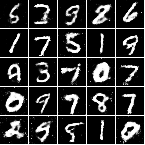

In [10]:
from IPython.display import Image
Image(filename='./GAN_generated_images/epoch69.png') 